# NLP Analysis
- Naive Bayes (Pairwise & Combined)
- K-Means Clustering (Without r/Parenting)

#### Importing Required Libraries

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from itertools import combinations

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import MDS, TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


#### Importing the Dataset

In [3]:
df = pd.read_csv('data/reddit_parenting_combined.csv') 
df.dropna(inplace=True, subset=['selftext_clean'])

In [4]:
df.sample(2)

,ID,title,author,created_time,url,score,permalink,subreddit,selftext,num_comments,is_self,link_flair_text,link_flair_css_class,upvote_ratio,over_18_content,tag,selftext_clean,title_clean
6770,1fpgg87,"F you, I hate you.",Separate_Yak_4327,2024-09-25 22:55:37+01:00,https://www.reddit.com/r/Parenting/comments/1f...,588,/r/Parenting/comments/1fpgg87/f_you_i_hate_you/,Parenting,Whilst walking through Costco today my son (7)...,431,True,Child 4-9 Years,child,0.91,False,Child 4-9 Years,whilst walking costco today son kept going pal...,f hate
7130,1axi0ez,What generational norm are you breaking?,DistributionWild4724,2024-02-22 21:17:11+00:00,https://www.reddit.com/r/Parenting/comments/1a...,382,/r/Parenting/comments/1axi0ez/what_generationa...,Parenting,"I’m letting my kids be mad, angry, unreasonabl...",337,True,Child 4-9 Years,child,0.93,False,Child 4-9 Years,im letting kids mad angry unreasonable cranky ...,generational norm breaking


In [5]:
df.subreddit.value_counts()

subreddit
Parenting            2992
atheistparents       2322
MuslimParenting       766
CatholicParenting     696
Name: count, dtype: int64

In [6]:
sampled_data = pd.concat(
    [df[df['subreddit'] == subreddit].sample(n=650, random_state=1)
      for subreddit in df.subreddit.unique()]
)

In [7]:
sampled_data.subreddit.value_counts()

subreddit
CatholicParenting    650
atheistparents       650
MuslimParenting      650
Parenting            650
Name: count, dtype: int64

### Generating TFID Vectors

In [8]:
def generate_tfidf_matrix(texts, max_terms=50, min_doc_freq=2):
    """
    Generate TF-IDF matrix and feature names from texts.
    """

    vectorizer = TfidfVectorizer(
        stop_words=stopwords.words('english'),
        max_features=max_terms,
        min_df=min_doc_freq
    )
    
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    return tfidf_matrix, feature_names

In [9]:
tfidf_matrix, feature_names = generate_tfidf_matrix(sampled_data.selftext.values)

In [10]:
tfid_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfid_df.head(5)


,also,baby,child,children,could,daughter,day,even,family,feel,...,things,think,time,told,us,want,way,wife,would,year
0,0.0,0.0,0.000000,0.667745,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.341648,0.000000,0.0,0.0,0.282575,0.000000
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.756882,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.653552
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.225832,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.282935,0.000000,0.0,0.0,0.000000,0.0,0.280186,0.0,...,0.0,0.278644,0.0,0.0,0.000000,0.235269,0.0,0.0,0.000000,0.000000


---
## NBC (Naive Bayes Classifier)

In [ ]:
X, label_names = generate_tfidf_matrix(sampled_data.selftext_clean.values, max_terms=250, min_doc_freq=3)
y = sampled_data.subreddit

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(X_train.shape, X_test.shape) 

(2080, 250) (520, 250)


### Pairwise Naive Bayes Classification

In [62]:
# Get unique subreddit classes
subreddit_classes = y.unique()

results =[]

# Loop through each pair of subreddit classes
for class1, class2 in combinations(subreddit_classes, 2):
    # Filter data to only include the current pair of classes
    pair_mask = y.isin([class1, class2])
    X_pair = X[pair_mask]
    y_pair = y[pair_mask]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_pair, y_pair, test_size=0.2, random_state=1)

    # Train Naive Bayes classifier
    nbc = MultinomialNB()
    nbc.fit(X_train, y_train)
    nbc_pred = nbc.predict(X_test)

    # Calculate accuracy for the pair
    accuracy = accuracy_score(y_test, nbc_pred)

    # Append results to the array as a dictionary
    results.append({"Class1": class1, "Class2": class2, "Accuracy": accuracy})

In [52]:
# Convert results list to DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by='Accuracy', ascending=False)

,Class1,Class2,Accuracy
2,CatholicParenting,Parenting,0.919231
3,atheistparents,MuslimParenting,0.915385
4,atheistparents,Parenting,0.911538
0,CatholicParenting,atheistparents,0.880769
1,CatholicParenting,MuslimParenting,0.873077
5,MuslimParenting,Parenting,0.865385


#### **Multinomial NBC Feature Importance (Top Words for the Classifer)**

In [64]:
# Generate TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=250)
X = vectorizer.fit_transform(sampled_data.selftext_clean)
y = sampled_data.subreddit

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Naive Bayes Classification
nbc = MultinomialNB()
nbc.fit(X_train, y_train)
nbc_pred = nbc.predict(X_test)

# Analyze results
print("Naive Bayes Classification Results:")
print(classification_report(y_test, nbc_pred))

Naive Bayes Classification Results:
                   precision    recall  f1-score   support

CatholicParenting       0.77      0.74      0.75       125
  MuslimParenting       0.75      0.64      0.69       130
        Parenting       0.64      0.87      0.74       129
   atheistparents       0.86      0.73      0.79       136

         accuracy                           0.74       520
        macro avg       0.76      0.74      0.74       520
     weighted avg       0.76      0.74      0.74       520



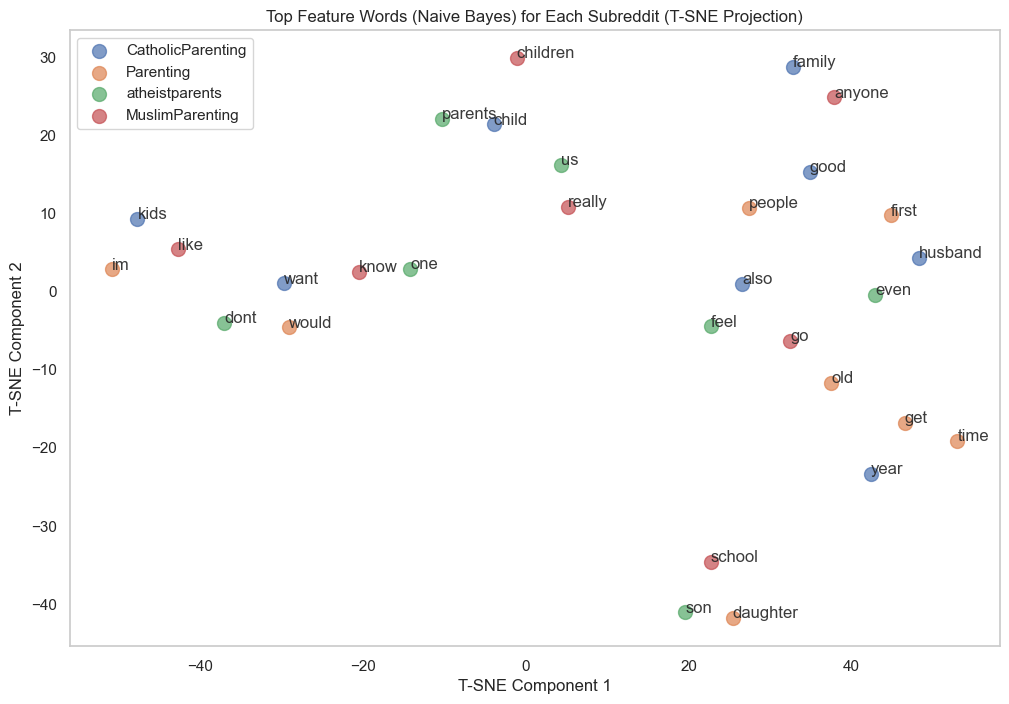

In [73]:
# Plotting
# Get feature names and log-probabilities for each class
feature_names = vectorizer.get_feature_names_out()
class_log_probs = nbc.feature_log_prob_

# Choose top N words across all classes based on average importance
top_n = 30
mean_log_probs = np.mean(class_log_probs, axis=0)
top_features_indices = np.argsort(mean_log_probs)[-top_n:]
top_features = feature_names[top_features_indices]
top_feature_values = class_log_probs[:, top_features_indices]

# Apply T-SNE to the selected top feature values across classes
tsne = TSNE(n_components=2, perplexity=5, random_state=1)
top_features_2d = tsne.fit_transform(top_feature_values.T)

# Plotting
plt.figure(figsize=(12, 8))
for i, subreddit in enumerate(y_train.unique()):
    plt.scatter(top_features_2d[i::len(y_train.unique()), 0], 
                top_features_2d[i::len(y_train.unique()), 1], 
                label=subreddit, s=100, alpha=0.7)

# Annotate with feature words
for i, word in enumerate(top_features):
    plt.annotate(word, (top_features_2d[i, 0], top_features_2d[i, 1]), fontsize=12, alpha=0.9)

plt.title("Top Feature Words (Naive Bayes) for Each Subreddit (T-SNE Projection)")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend()
plt.grid(False)
plt.show()

---
## K-Means Clustering

In [89]:
# Not considering the 'r/Parenting' subreddit
not_parent_df = sampled_data[sampled_data['subreddit'] != 'Parenting']
tfidf_matrix, labels = generate_tfidf_matrix(not_parent_df.selftext_clean.values, max_terms=100, min_doc_freq=2)

### Elbow Plot

In [90]:
# Lists to store inertia and silhouette scores for different values of k
inertia_values = []
silhouette_scores = []
k_values = range(2, 11)  # Testing k values from 2 to 10

# Loop over different values of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(tfidf_matrix)
    
    # Append inertia and silhouette scores
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(tfidf_matrix, clusters))


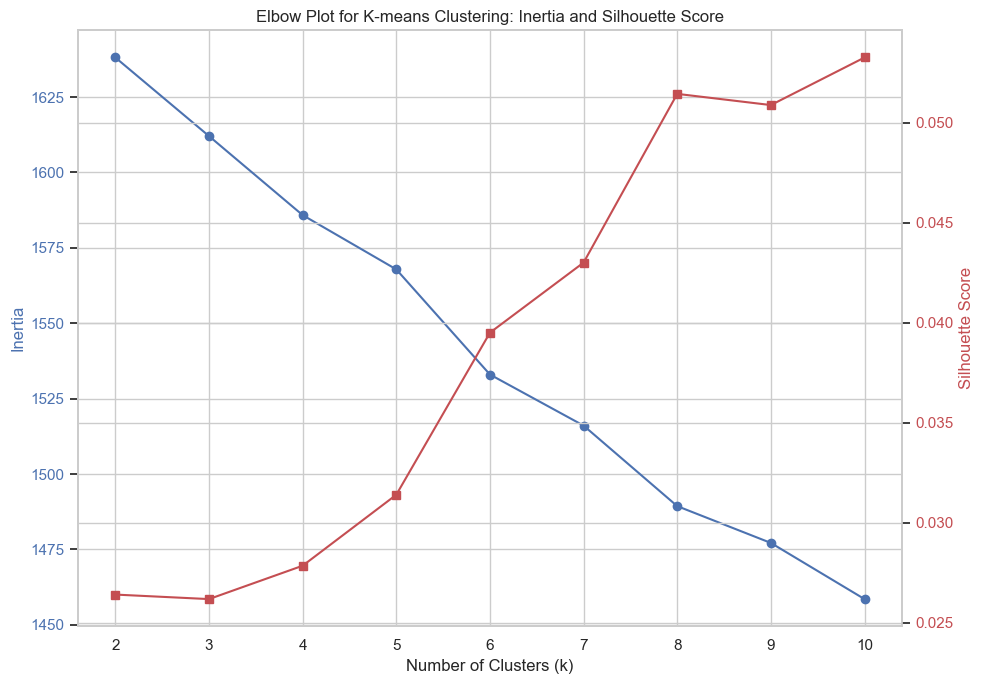

In [91]:
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot inertia on the primary y-axis
ax1.plot(k_values, inertia_values, 'b-o', label="Inertia")
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis to plot the silhouette score
ax2 = ax1.twinx()
ax2.plot(k_values, silhouette_scores, 'r-s', label="Silhouette Score")
ax2.set_ylabel("Silhouette Score", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and legend
plt.title("Elbow Plot for K-means Clustering: Inertia and Silhouette Score")
fig.tight_layout()
plt.show()


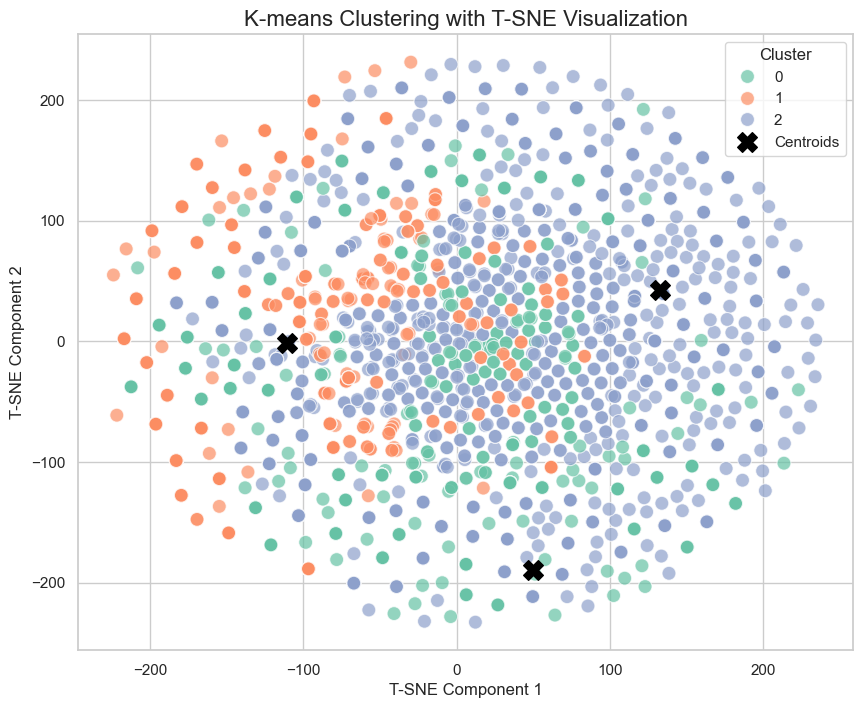

In [87]:
# Preprocessing: Convert text data to TF-IDF
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=250)
X = vectorizer.fit_transform(not_parent_df.selftext_clean)

# Apply K-means clustering
num_clusters = 3  # Define the number of clusters you want to create
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Get the cluster labels
labels = kmeans.labels_

# Apply T-SNE for dimensionality reduction (2D visualization)
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
X_tsne = tsne.fit_transform(X.toarray())

# Create a DataFrame to store the t-SNE output and the cluster labels
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE_1', 'TSNE_2'])
df_tsne['Cluster'] = labels

# Plotting the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_tsne, x='TSNE_1', y='TSNE_2', hue='Cluster', palette='Set2', s=100, alpha=0.7)

# Add centroids for the clusters
centroids = tsne.fit_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label='Centroids')

# Customize the plot
plt.title("K-means Clustering with T-SNE Visualization", fontsize=16)
plt.xlabel("T-SNE Component 1", fontsize=12)
plt.ylabel("T-SNE Component 2", fontsize=12)
plt.legend(title="Cluster", loc='upper right')
plt.show()

---

## Exploration

### T-SNE Plots
**Using Bernie's Code**

In [ ]:
def plot_word_similarities_tsne(tfidf_matrix, feature_names, n_highlight=10, perplexity=30, title=None):
    """
    Plot word similarities using t-SNE with all terms but highlighting top N.
    """
    # Get vectors for all terms
    term_vectors = tfidf_matrix.T.toarray()
    
    # Identify top terms
    mean_tfidf = tfidf_matrix.mean(axis=0).A1
    top_indices = mean_tfidf.argsort()[-n_highlight:][::-1]
    top_terms = feature_names[top_indices]
    
    # Calculate t-SNE for all terms
    tsne = TSNE(n_components=2, 
                perplexity=min(30, len(feature_names)/4), 
                random_state=42)
    coords = tsne.fit_transform(term_vectors)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot all points in light gray
    ax.scatter(coords[:, 0], coords[:, 1], 
              c='lightgray', alpha=0.5, s=30)
    
    # Highlight top terms
    ax.scatter(coords[top_indices, 0], coords[top_indices, 1], 
              c='red', s=100)
    
    # Add labels for top terms
    for i, term in enumerate(top_terms):
        ax.annotate(term, 
                   (coords[top_indices[i], 0], coords[top_indices[i], 1]),
                   fontsize=14,
                   bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7)
        )
    if title:
        ax.set_title(f'Word Similarities in {title} (Top {n_highlight} Terms Highlighted)')
    else:
        ax.set_title(f'Word Similarities (Top {n_highlight} Terms Highlighted)')
    plt.tight_layout()
    return fig, ax

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in Reddit Parenting (Top 10 Terms Highlighted)'}>)

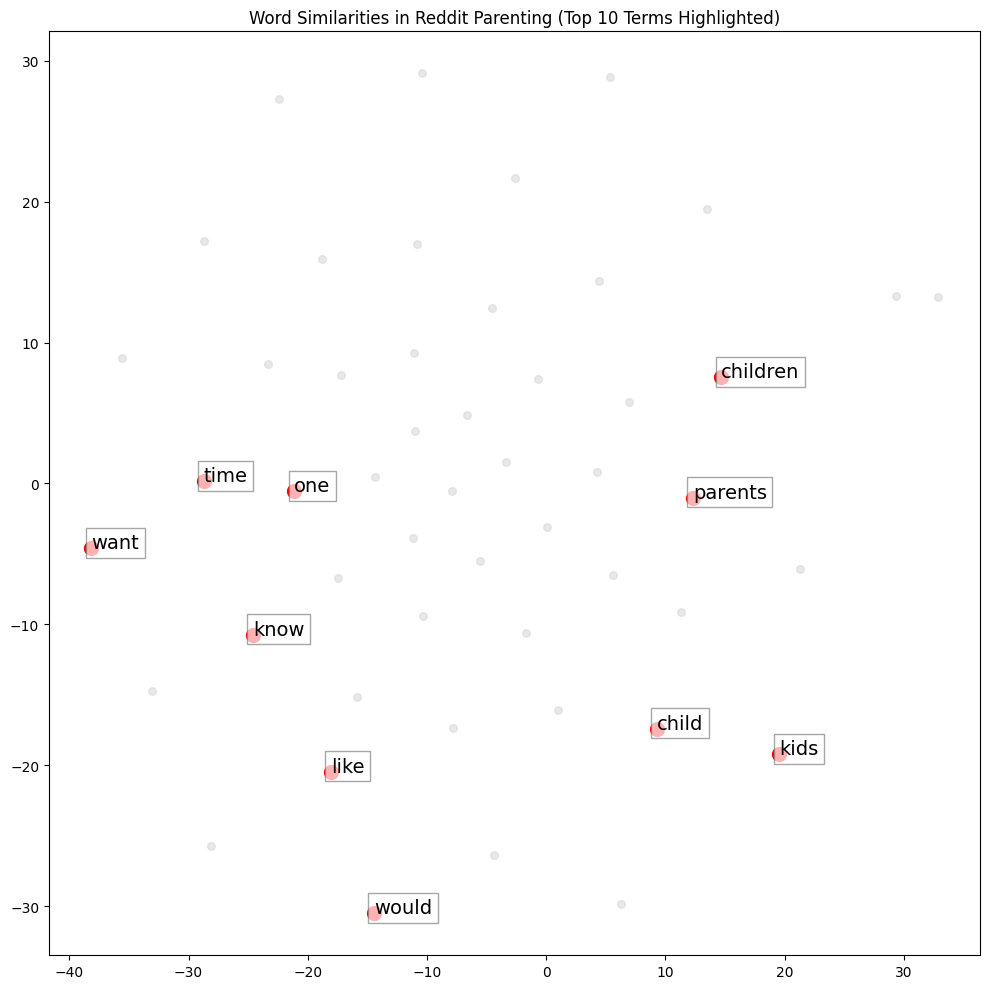

In [ ]:
plot_word_similarities_tsne(tfidf_matrix, feature_names, title='Reddit Parenting')

In [ ]:
def split_label(label, max_line_length=25, max_lines=2):
    """Split label at the nearest space before max_line_length and return max_lines"""
    lines = []
    temp_label = label
    
    while len(temp_label) > max_line_length:
        split_index = temp_label.rfind(' ', 0, max_line_length)
        if split_index == -1:
            split_index = max_line_length
        lines.append(temp_label[:split_index])
        temp_label = temp_label[split_index:].strip()
        
    lines.append(temp_label)
    
    return '\n'.join(lines[:max_lines])

def plot_similarities(tfidf_matrix, labels, 
                      title="term document plot", 
                        method='tsne', is_documents=True, label_color=False,
                      top_terms=None, figsize=(12, 8)):
    """
    Create projection visualization of document or term similarities
    
    Parameters:
    - tfidf_matrix: scipy sparse matrix
    - labels: list of labels (document texts or terms)
    - title: plot title
    - method: 'tsne' or 'mds' for dimensionality reduction
    - top_terms: if int, only annotate top n terms
    - is_documents: if True, plot documents, else plot terms
    - figsize: tuple for figure size
    """

    # Convert to dense array and transpose if visualizing terms
    matrix = tfidf_matrix.toarray()
    if not is_documents:
        matrix = matrix.T
    
    # Dimensionality reduction method
    if method == 'tsne':
        tsne = TSNE(n_components=2, 
                    perplexity=min(30, len(labels)-1),
                    random_state=42)
        coords = tsne.fit_transform(matrix)
    elif method == 'mds':
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        distances = 1 - cosine_similarity(matrix)
        coords = mds.fit_transform(distances)
    else:
        raise ValueError("Method must be 'tsne' or 'mds'") 
    
    # Create visualization
    fig, ax = plt.subplots(figsize=figsize)
    scatter = ax.scatter(coords[:, 0], coords[:, 1], alpha=0.6)
    
    # Add labels
    if top_terms and isinstance(top_terms, int):
        mean_tfidf = tfidf_matrix.mean(axis=0).A1 if is_documents else tfidf_matrix.mean(axis=1).A1
        top_indices = mean_tfidf.argsort()[-top_terms:][::-1]
        labels_to_annotate = [labels[i] for i in top_indices]
        coords_to_annotate = coords[top_indices]
    else:
        labels_to_annotate = labels
        coords_to_annotate = coords

    if label_color:
        unique_labels = list(set(labels_to_annotate))
        color_map = {label: color for label, color in zip(unique_labels, plt.cm.rainbow(np.linspace(0, 1, len(unique_labels))))}
        colors = [color_map[label] for label in labels_to_annotate]
    else:
        colors = ['black'] * len(labels_to_annotate)
    
    for i, (label, color) in enumerate(zip(labels_to_annotate, colors)):
        # Split long labels for documents
        if is_documents:
            label = split_label(label, 20)
            
        ax.annotate(label, (coords_to_annotate[i, 0], coords_to_annotate[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8 if is_documents else 12, alpha=0.7, color=color)
    
    
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.3)
    return fig, ax

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Reddit Parenting'}>)

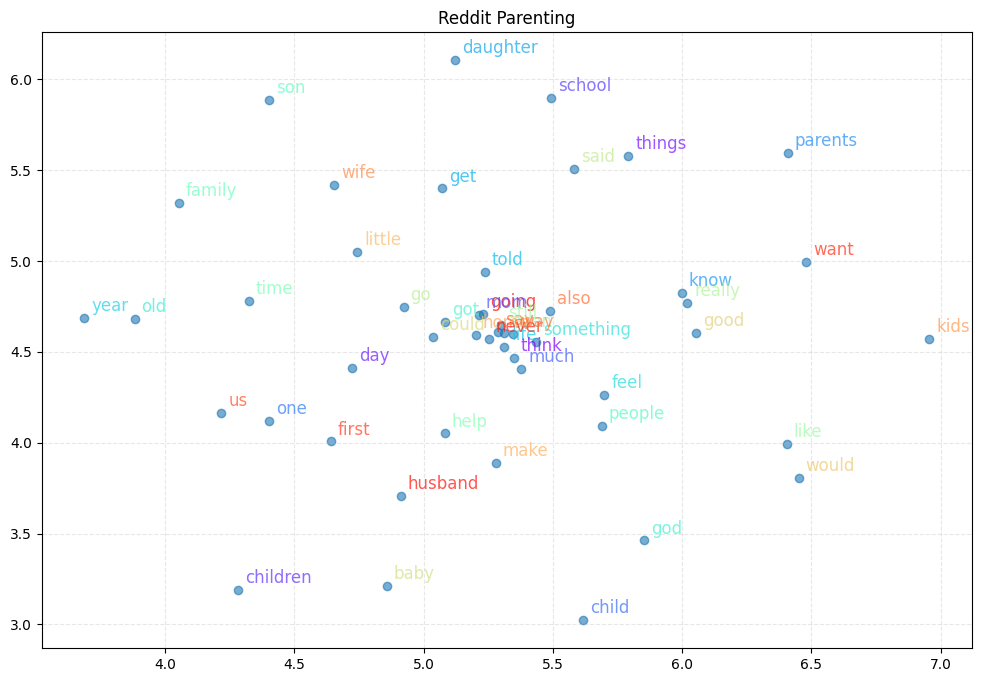

In [ ]:
plot_similarities(tfidf_matrix, feature_names, title='Reddit Parenting', label_color=True, is_documents=False)

---